# Individual Recommender Systems - Tutorial 1 (Lab 1)


In this tutorial, we will see some implementations of strategies for individual recommender systems seen in the first lectures of the course. At the same time, we will introduce some libraries useful for machine learning applications in python. After completing this tutorial, you will be able to: 
- Create a non-personalized recommender system in the domain of movies for individual users.
- Create a personalized recommender system using either a content based or a collaborative filtering approach.
- Evaluate the performance of the recommender systems, using different evaluation protocols.


#### Summary

1. Dataset
2. Non personalized recommendations: ordering by average rating
3. Towards personalization: Filtering by genre
4. Content Based Recommender System
5. Collaborative Filtering Recommender System
6. Evaluation of Recommender Systems
    1. Evaluation of a CB recommender
    2. Evaluation of a CF recommender



#### 1. Dataset


We will use the preprocessed dataset provided in the folder *preprocessed_dataset*. The dataset has been obtained from the 
[Movielens latest small](https://www.kaggle.com/grouplens/movielens-latest-small) dataset (providing user's ratings) and the [Wikipedia Movie Plots](https://www.kaggle.com/jrobischon/wikipedia-movie-plots) dataset (providing movies' information). Check the notebook **Dataset Preprocessing** for details on how the datasets have been preprocessed and merged.

The dataset contains two CSV files, following  the structure of the Movielens dataset:
1. ratings.csv: contains the information about the feedback of the users for the movies. Each row contains the id of a user,the id of a movie, and the rating that the user gave to the movie. It also contains the timestamp, but we will not use it in this tutorial.
2. movies.csv: contains the information about the movies. In particular, we will use the genre and the plot.



We start using the [pandas](https://pandas.pydata.org/) library to read the content of the CSV files and use it. Let us have a look at the first 10 rows of each file, to check which contents are provided by the *ratings.csv* and the *movies.csv* files. To do so, we use the *read_csv* method which returns a pandas [Dataframe](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) object containing the information read from the csv file. Such object provides several methods to manipulate the data in it, and we will use the [head](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html) method, which returns the first *n* rows of the dataframe. We use also the [display](https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html#IPython.display.display) method, that allows to print information nicely in a jupyter notebook.

In [1]:
preprocessed_dataset_folder = "../preprocessed_dataset"

import pandas as pd

In [2]:
ratings_df = pd.read_csv(preprocessed_dataset_folder+"/ratings.csv") 
display(ratings_df.head(10))

,user,item,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,70,3.0,964982400
4,1,101,5.0,964980868
5,1,110,4.0,964982176
6,1,151,5.0,964984041
7,1,157,5.0,964984100
8,1,163,5.0,964983650
9,1,216,5.0,964981208


In [3]:
movies_df = pd.read_csv(preprocessed_dataset_folder+"/movies.csv", index_col="item")
display(movies_df.head(10))

,title,year,genres,plot
item,,,,
1,toy story,1995,Adventure|Animation|Children|Comedy|Fantasy,In a world where toys are living things who pr...
2,jumanji,1995,Adventure|Children|Fantasy,"In 1869, near Brantford, New Hampshire, two br..."
3,grumpier old men,1995,Comedy|Romance,The feud between Max (Walter Matthau) and John...
4,waiting to exhale,1995,Comedy|Drama|Romance,"""Friends are the People who let you be yoursel..."
5,father of the bride part ii,1995,Comedy,The film begins five years after the events of...
6,heat,1995,Action|Crime|Thriller,"Neil McCauley, a career criminal, hires Waingr..."
7,sabrina,1995,Comedy|Romance,Sabrina Fairchild is the young daughter of the...
8,tom and huck,1995,Adventure|Children,The movie opens with Injun Joe (Eric Schweig) ...
9,sudden death,1995,Action,Darren McCord (Jean-Claude Van Damme) is a Fre...


Let us have a look at the number of ratings we have for each movie. First, we select the columns *user* and *item*. Then, we can use the [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) method to group the columns given a specific column value. The method returns a [Groupby](https://pandas.pydata.org/docs/reference/groupby.html) object, which provides methods to aggregate the values of each group. We aggregate by *item*, to count the number of users that rated each item. To compute this, we use the [count](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.count.html) method which returns a Dataframe object, in which we will have a row for each movie, and the number of users who rated each movie in the *user* column.

Then, we visualize the distribution of the number of evaluations for each movie using the [seaborn](https://seaborn.pydata.org/) library. We use the [displot](https://seaborn.pydata.org/generated/seaborn.histplot.html#seaborn.displot) method, specifying `x='user'`.

,user
item,
1,215
2,110
3,52
4,7
5,49
...,...
181315,1
182823,4
191005,1


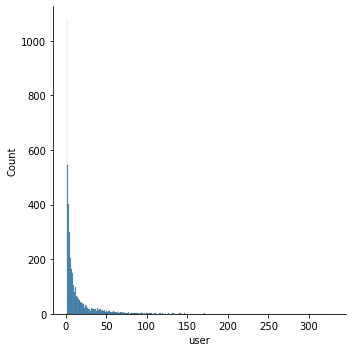

In [4]:
import seaborn as sns

count_ratings_df = ratings_df[['user','item']].groupby(['item']).count()
display(count_ratings_df)
sns.displot(data=count_ratings_df, x='user', binwidth=1)

Note that here, we have on the horizontal axe the number of users that evaluated a movie, and on the vertical axe the number of movies having the corresponding number of evaluations. We migh want to visuaize instead on the horizontal axe the movies, and on the vertical axe the number of users who evaluated it. There are different ways to do it, we will just sort the previous Dataframe by *user* (i.e. the number of user evaluations for the corresponding movie) in a descending order, using the [sort_values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method of the Dataframe object, and then reset the index two times, in order to have a progressive id for the movies (the [reset_index](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reset_index.html) function will create a nerw index assigning a progressive identifier to each row in the Dataframe). The, we just plot the line having *index* on the horizontal axe and *user* on the vertical axe. 

,index,item,user
0,0,356,329
1,1,296,307
2,2,480,238
3,3,110,237
4,4,589,224
...,...,...,...
4620,4620,44197,1
4621,4621,4402,1
4622,4622,44189,1
4623,4623,4408,1


<AxesSubplot:xlabel='index', ylabel='user'>

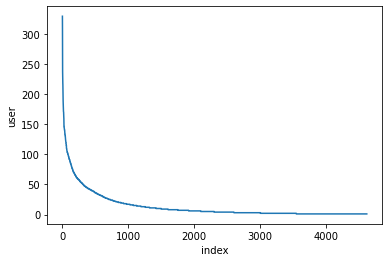

In [5]:
count_ratings_df_ord = count_ratings_df.sort_values(by="user", ascending=False).reset_index().reset_index()
display(count_ratings_df_ord)
sns.lineplot(data=count_ratings_df_ord, x='index', y='user')

Is this what you expected? Does this reming you of something?

![title](img/The-long-tail-dinosaur.png)

#### 2. Non personalized recommendations: ordering by average rating

A first idea to provide recommendations for our users can be to use the ratings provided and determine the highest rated movies. To do so, we first need to compute the average rating for each movie, and then determine the top rated. Let's use again the functions provided by the Dataframe object. We can use the [groupby](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) again. To compute the average ratings, we use the [mean](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.mean.html) method which returns a Dataframe object, in which we will have a row for each movie, and the average rating will be in the *rating* column. Finally, we use the [sort_values](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html) method to sort the movies by rating, and we print the first 10 movies.

In [6]:
average_ratings_df = ratings_df.groupby(['item']).mean()
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False)

display(sorted_avg_ratings_df.head(10))

,user,rating,timestamp
item,,,
4402,441.0,5.0,1.449071e+09
96608,89.0,5.0,1.520409e+09
131237,105.0,5.0,1.446619e+09
33138,187.0,5.0,1.161955e+09
84512,89.0,5.0,1.520409e+09
82744,380.0,5.0,1.493422e+09
164367,534.0,5.0,1.487278e+09
99636,106.0,5.0,1.467567e+09
107771,610.0,5.0,1.479544e+09


Let's use the information in the *movies_df* to associate the title on each movie, and then print the list of recommended movies. We will use the [join](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.join.html) method of the Dataframe object. Remember that the attribute you specify with the *on* parameter must be the index of the second dataframe.

In [7]:
joined_df = sorted_avg_ratings_df.join(movies_df, on='item')
display(joined_df.head(10))

,user,rating,timestamp,title,year,genres,plot
item,,,,,,,
4402,441.0,5.0,1.449071e+09,dr. goldfoot and the bikini machine,1965,Comedy,"Price plays the titular mad scientist who, wit..."
96608,89.0,5.0,1.520409e+09,runaway brain,1995,Animation|Comedy|Sci-Fi,Minnie visits Mickey while he is playing a Sno...
131237,105.0,5.0,1.446619e+09,what men talk about,2010,Comedy,"What Men Talk About? Of course, women. But als..."
33138,187.0,5.0,1.161955e+09,palindromes,2004,Adventure|Comedy|Drama,The film opens with a funeral for a young woma...
84512,89.0,5.0,1.520409e+09,girls about town,1931,Comedy,Wanda Howard (Kay Francis) and Marie Bailey (L...
82744,380.0,5.0,1.493422e+09,faster,2010,Action|Crime|Drama,"Upon leaving prison, ""Driver"" breaks into a ru..."
164367,534.0,5.0,1.487278e+09,the girl with all the gifts,2016,Drama|Horror|Sci-Fi|Thriller,"In the near future, humanity has been ravaged ..."
99636,106.0,5.0,1.467567e+09,english vinglish,2012,Comedy|Drama,Shashi Godbole (Sridevi) is a homemaker who ma...
107771,610.0,5.0,1.479544e+09,only lovers left alive,2013,Drama|Horror|Romance,Married for centuries and now living half a wo...


The movie we recommend are not so famous. Why is this happening? Let's check how many people rated each of these movies. We use again the *group_by* method, and then we use the [agg](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.GroupBy.agg.html) method of the Groupby onject to specify different aggregations: for the *user*, we are going to count the number of users in the group, using the *'size'* input, while for the rating we want the average value, so we specify *'mean'*. The rest of the operations are the same as before:

In [8]:
average_ratings_df = ratings_df.groupby(['item']).agg(count=('user', 'size'), rating=('rating', 'mean')).reset_index()
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False)
joined_df = sorted_avg_ratings_df.join(movies_df, on='item')
display(joined_df[['title', 'count', 'rating']].head(10))

,title,count,rating
1910,dr. goldfoot and the bikini machine,1,5.0
4055,runaway brain,1,5.0
4377,what men talk about,1,5.0
3164,palindromes,1,5.0
3881,girls about town,1,5.0
3869,faster,1,5.0
4532,the girl with all the gifts,1,5.0
4097,english vinglish,1,5.0
4200,only lovers left alive,1,5.0
4113,maniac cop 2,1,5.0


We can see that all the movies we selected have been rated by only one user. Let's try to recommend only movies that have been rated by at least 20 users. Note that the *item* column is the index for the Dataframe object obtained using the *mean* and *count* methods. We will use the [loc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.loc.html) attribute of the Dataframe object, which allows to access a group of rows and columns by label(s) or a boolean array. In particular, we will determine a Series of boolean: The instruction `rating_counts_df['rating'] > minimum_ratings` evaluate the condition for each row of the *rating* column. Hence, *loc* will only return the rows for which such condition is true.

In [9]:
minimum_ratings = 20
average_ratings_df = ratings_df.groupby(['item']).mean() #compute the average ratings for each movie
rating_counts_df = ratings_df.groupby(['item']).count() #compute the number of evaluations for each movie
average_ratings_df = average_ratings_df.loc[rating_counts_df['rating'] > minimum_ratings] #select the movies having the required number of evaluations
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False) #sort the movies according to the average ratings
joined_df = sorted_avg_ratings_df.join(movies_df['title'], on='item') #associate the title
display(joined_df[['title','rating']].head(10))

,title,rating
item,,
1204,lawrence of arabia,4.300000
1235,harold and maude,4.288462
168252,logan,4.280000
2959,fight club,4.272936
1276,cool hand luke,4.271930
750,dr. strangelove or: how i learned to stop worr...,4.268041
904,rear window,4.261905
1213,goodfellas,4.250000
912,casablanca,4.240000


We can see now that the recommendation contains more famous movies.

#### 3. Towards personalization: filtering by genre

Now, let us try to make a personalized recommender system. One possible solution is to suggest movies having the highest ratings for a specific genre. We also want to only select movies evaluated by at least 20 users. We use the same methods used in the previous example. To select the movies by genre, we need to check if the value in the column *genre* contains the specified genre. We can write the conditions as `average_ratings_df['genres'].str.contains(genre)`. 

In [10]:
genre = 'Action'
minimum_ratings = 20

average_ratings_df = ratings_df.groupby(['item']).mean() #compute the average ratings for each movie
rating_counts_df = ratings_df.groupby(['item']).count() #compute the number of evaluations for each movie
average_ratings_df = average_ratings_df.loc[rating_counts_df['rating'] > minimum_ratings] #select the movies having the required number of evaluations
average_ratings_df = average_ratings_df.join(movies_df['genres'], on='item')
average_ratings_df = average_ratings_df.loc[average_ratings_df['genres'].str.contains(genre)]
sorted_avg_ratings_df = average_ratings_df.sort_values(by="rating", ascending=False) #sort the movies according to the average ratings
joined_df = sorted_avg_ratings_df.join(movies_df['title'], on='item') #associate the title
display(joined_df[['title','rating','genres']].head(10))

,title,rating,genres
item,,,
168252,logan,4.280000,Action|Sci-Fi
2959,fight club,4.272936,Action|Crime|Drama|Thriller
1208,apocalypse now,4.219626,Action|Drama|War
908,north by northwest,4.184211,Action|Adventure|Mystery|Romance|Thriller
2028,saving private ryan,4.146277,Action|Drama|War
68157,inglourious basterds,4.136364,Action|Drama|War
541,blade runner,4.100806,Action|Sci-Fi|Thriller
79132,inception,4.066434,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
112852,guardians of the galaxy,4.050847,Action|Adventure|Sci-Fi


We can see here the genres associated to the chosen movies. A movie can belong to multiple genres, some of which a user likes, and some he/she dislike. 

#### 4. Content Based Recommender System

Let us try to implement some of the strategies seen during the lectures to provide more personalized recommendations. We start from a content based approach. We will start implementing the recommnender for a specific user. We will see the following steps:
- Selection of a random user
- Retrieving the information of the rated and unrated movies for the selected user
- Compute a feature representation for the movie's contents (TF-IDF)
- Train a regressor, computing of the predicted ratings for unrated movies, and recommending the movies with higher predicted ratings

##### 4.1 Selection of a random user


For simplicity, we select a random user from the *ratings_df* Dataframe having more than 200 evaluations. First, we select all the users with more than 200 evaluations, and then we use the [sample](https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.sample.html) method to extract a random row. Finally, we extract the *user* column and we read the content with the [iloc](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.iloc.html) method.

In [11]:
users_ratings = ratings_df.groupby(['user']).count()

selected = users_ratings['rating'] > 200
selected_users = users_ratings.loc[selected]
random_selected = selected_users.sample() # sample() returns a random row from the dataframe. The returned object is a dataframe with one row. If you pass a number as argument you specify to select more than one row.
select_column_df = random_selected.reset_index()['user'] # reset_index() create a new index, and the user became a column. Then, we can filter using the column name
selected_user = select_column_df.iloc[0] # iloc select by index, since our dataframe only has one row we read it from the index 0
print("Selected user: " + str(selected_user))

Selected user: 517


##### 4.2 Retrieving the information of the rated and unrated movies for the selected user

Now, we need to select the user evaluations, that we will use to train our recommender. We print the number of ratings that we have for the considered user, and the extracted dataset, ordered by ratings.

In [12]:
selected_user_ratings = ratings_df.loc[ratings_df['user'] == selected_user]
selected_user_ratings = selected_user_ratings.sort_values(by='item', ascending=True)
print("Rated movies: " + str(selected_user_ratings.shape[0]))
display(selected_user_ratings.head(10))

Rated movies: 252


,user,item,rating,timestamp
52269,517,1,4.0,1487954343
52270,517,2,3.0,1487954340
52271,517,10,0.5,1487957717
52272,517,17,0.5,1487953834
52273,517,34,5.0,1487954303
52274,517,107,1.0,1487956132
52275,517,110,1.5,1487953160
52276,517,158,2.0,1487954337
52277,517,277,5.0,1487955694
52278,517,344,2.5,1487966186


Now, we need the select content of the rated movies, that we will need to compute the features that our model will use. We do it by selecting the rows from our *movies_df* dataframe having a *item* that is in the list of *item* of the *selected_user_ratings* Dataframe, which only contains the evaluations of the considered user. We do this using the [isin](https://pandas.pydata.org/docs/reference/api/pandas.Series.isin.html) method. Since the *item* is the index in the *movies_df* Dataframe, we can select directly pass the list of *item* we want to select to *loc*, and it will return the rows for which the index is in the considered list. Finally, we only select the columns *title* and *plot*.

In [13]:
rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])]
rated_movies_df = rated_movies_df[['title', 'plot']]
print("Rated movies: " + str(rated_movies_df.shape[0]))
display(rated_movies_df.head(10))

Rated movies: 252


,title,plot
item,,
1,toy story,In a world where toys are living things who pr...
2,jumanji,"In 1869, near Brantford, New Hampshire, two br..."
10,goldeneye,"In 1986, at Arkhangelsk, MI6 agents James Bond..."
17,sense and sensibility,"On his deathbed, Mr. Dashwood tells his son fr..."
34,babe,"Babe, an orphaned piglet, is chosen for a ""gue..."
107,muppet treasure island,Jim Hawkins is a young orphan who lives in the...
110,braveheart,"In 1280, King Edward ""Longshanks"" invades and ..."
158,casper,"In the town of Friendship, Maine, two young bo..."
277,miracle on 34th street,Kris Kringle (Edmund Gwenn) is indignant to fi...


We use a similar approach to select the unrated movies. We compute the set of movies index that are not rated using the set subtraction operator. We access the index of the *movies_df* and the *rated_movies_df* Dataframes, create two sets containing such indexes, compute the difference set *diff*, and select the movies having an  index in the *diff* set.

In [14]:
diff = set(movies_df.index) - set(rated_movies_df.index)
unrated_movies_df = movies_df.loc[diff]
unrated_movies_df = unrated_movies_df[['title', 'plot']]
print("Unrated movies: " + str(unrated_movies_df.shape[0]))
display(unrated_movies_df.head(10))

Unrated movies: 4381


,title,plot
item,,
3,grumpier old men,The feud between Max (Walter Matthau) and John...
4,waiting to exhale,"""Friends are the People who let you be yoursel..."
5,father of the bride part ii,The film begins five years after the events of...
6,heat,"Neil McCauley, a career criminal, hires Waingr..."
7,sabrina,Sabrina Fairchild is the young daughter of the...
8,tom and huck,The movie opens with Injun Joe (Eric Schweig) ...
9,sudden death,Darren McCord (Jean-Claude Van Damme) is a Fre...
180231,daddy's home 2,After finally becoming friends at the end of t...
12,dracula: dead and loving it,Solicitor Thomas Renfield travels all the way ...


Finally, we can add the rating so that we just need to work with a single Dataframe. We do it using the *join* method. We specify the *item* as idex in the *selected_user_ratings* Dataframe to procede with the join. The we select the *rating* column.

In [15]:
rated_movies_df = rated_movies_df.join(selected_user_ratings.set_index('item')['rating'], on='item')
print("Rated movies: " + str(rated_movies_df.shape[0]))
display(rated_movies_df.head(10))

Rated movies: 252


,title,plot,rating
item,,,
1,toy story,In a world where toys are living things who pr...,4.0
2,jumanji,"In 1869, near Brantford, New Hampshire, two br...",3.0
10,goldeneye,"In 1986, at Arkhangelsk, MI6 agents James Bond...",0.5
17,sense and sensibility,"On his deathbed, Mr. Dashwood tells his son fr...",0.5
34,babe,"Babe, an orphaned piglet, is chosen for a ""gue...",5.0
107,muppet treasure island,Jim Hawkins is a young orphan who lives in the...,1.0
110,braveheart,"In 1280, King Edward ""Longshanks"" invades and ...",1.5
158,casper,"In the town of Friendship, Maine, two young bo...",2.0
277,miracle on 34th street,Kris Kringle (Edmund Gwenn) is indignant to fi...,5.0


Now, we have all the data we need to train a content based recomemnder system for our user.

##### 4.3 Compute a feature representation for the movie's contents (TF-IDF)

We will use the well-known pythion library [sklearn](https://scikit-learn.org/stable/) to train our recommender. First, we need to extract features from our content (the plots of the movies). Remember that we need a vector representing each document, in order to compare them. We use the TF-IDF model, hance we will use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class, which allows us to easily compute TF-IDF vectors for our movies. We need to instantiate the a *TfidfVectorizer* object, and then we need to use the [fit_transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit_transform) method. The method fits (trains) the features model, and then transform our data, returning the TF-IDF matrix representation. We use the [shape](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.shape.html#numpy.ndarray.shape) attribute of the matrix to check the dimensions of our features matrix.

In [16]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(rated_movies_df['plot'])
print(X.shape)

(252, 15553)


##### 4.4 Train a regressor, computing of the predicted ratings for unrated movies, and recommending the movies with higher predicted ratings

Now, we have our features. In this example, we will train a regressor, that is able to determine, for each unrated movie, an extimation of the rating that the user would assign to it. Of course, we could use a different approach, treating the problem as a classification problem. In that case, we would need to transform our ratings to obtain labels. We will see that later today. Now, for simplicity, we will work with the ratings. 

For the regressor, we will use the [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html) class of the sklearn library. We need to create an instance of *KNeighborsRegressor*. Remember that the KNN algorithm uses the similarity between items to compute the predictions. In the case of regression, the rating assigned to new item is computed based on the mean of the ratings of its nearest neighbors.

In the constructor, we specify the number of neighbors to use. We set it at 5. Finally, we can train our model, using the [fit](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.fit) method, passing as arguments the features matrix *X* and the corresponding ratings vector *y*.

In [17]:
from sklearn.neighbors import KNeighborsRegressor

y = rated_movies_df['rating']
neigh = KNeighborsRegressor(n_neighbors=5)
neigh.fit(X, y)

KNeighborsRegressor()

We can now use the trained model to compute our recommendations. First, we need to extract the features from our unrated movies plots. We can do it using the previously trained *TfidfVectorizer* *vectorizer*, passing to its method [transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.transform) the *Plot* column if the *unrated_movies* Dataframe. 

Then, we use the trained *KNeighborsRegressor* *neigh*, passing the features matrix of the unrated movies *x_unrated* to its [predict](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.predict) method, determining the predicted ratings *y_unrated*.

In [18]:
X_unrated = vectorizer.transform(unrated_movies_df['plot'])
print(X_unrated.shape)
y_unrated = neigh.predict(X_unrated)
print(y_unrated.shape)

(4381, 15553)
(4381,)


Finally, we can combine the predicted ratings with the information in the unrated_movies Dataframe, order the movies by predicted ratings, and determine the best 10 movies to recommend to the user.

In [19]:
unrated_movies_df['predicted_ratings_KNN'] = y_unrated
unrated_movies_df_KNN_ordering = unrated_movies_df.sort_values(by='predicted_ratings_KNN', ascending=False)
display(unrated_movies_df_KNN_ordering.head(10))

,title,plot,predicted_ratings_KNN
item,,,
378,speechless,Julia Mann (Davis) and Kevin Vallick (Keaton) ...,4.9
166534,split,Casey Cooke is an emotionally withdrawn teenag...,4.8
135887,minions,"Minions are small, yellow creatures who have e...",4.7
2146,st. elmo's fire,Recent Georgetown University graduates Alec (J...,4.7
93512,"jeff, who lives at home",Jeff (Segel) is a 30-year-old unemployed stone...,4.6
103801,drinking buddies,Kate (Olivia Wilde) and Luke (Jake Johnson) ar...,4.5
3991,102 dalmatians,"After three years in prison, Cruella de Vil ha...",4.5
8875,"come back, little sheba","""Doc"" Delaney (Burt Lancaster) is a recovering...",4.5
1620,kiss the girls,"Washington, D.C. detective and forensic psycho...",4.5


#### EXERCISE

Following the example above, implement a second content-based recommender system using the [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) regressor of the Sklearn library (use a *linear* kernel and the default hyperparameters).

##### Solution

In [20]:
from sklearn.svm import SVR

y = rated_movies_df['rating']
svr = SVR(kernel='linear')
svr.fit(X, y)

y_unrated_svr = svr.predict(X_unrated)
print(y_unrated_svr.shape)

unrated_movies_df['predicted_ratings_SVR'] = y_unrated_svr
unrated_movies_df_SVR_ordering = unrated_movies_df.sort_values(by='predicted_ratings_SVR', ascending=False)
display(unrated_movies_df_SVR_ordering.head(10))

display(unrated_movies_df_KNN_ordering.head(10))

(4381,)


,title,plot,predicted_ratings_KNN,predicted_ratings_SVR
item,,,,
3551,marathon man,"Thomas ""Babe"" Levy is a history Ph.D. candidat...",4.4,3.463060
1701,deconstructing harry,"One night, Lucy (Judy Davis) gets a taxi to th...",3.3,3.446647
1645,the devil's advocate,"Kevin Lomax, a defense attorney from Gainesvil...",3.8,3.387376
95170,beauty and the beast: the enchanted christmas,The film starts out with everybody getting pre...,3.4,3.263481
81834,harry potter and the deathly hallows: part 1,Minister of Magic Rufus Scrimgeour addresses t...,3.3,3.259427
3388,harry and the hendersons,George Henderson (John Lithgow) is returning t...,3.4,3.236945
1946,marty,Marty Piletti (Ernest Borgnine) is an Italian ...,4.1,3.228405
7215,to have and have not,"In the summer of 1940, world-weary Harry Morga...",3.3,3.168745
4880,life as a house,"George Monroe, an architectural model fabricat...",3.3,3.145636


,title,plot,predicted_ratings_KNN
item,,,
378,speechless,Julia Mann (Davis) and Kevin Vallick (Keaton) ...,4.9
166534,split,Casey Cooke is an emotionally withdrawn teenag...,4.8
135887,minions,"Minions are small, yellow creatures who have e...",4.7
2146,st. elmo's fire,Recent Georgetown University graduates Alec (J...,4.7
93512,"jeff, who lives at home",Jeff (Segel) is a 30-year-old unemployed stone...,4.6
103801,drinking buddies,Kate (Olivia Wilde) and Luke (Jake Johnson) ar...,4.5
3991,102 dalmatians,"After three years in prison, Cruella de Vil ha...",4.5
8875,"come back, little sheba","""Doc"" Delaney (Burt Lancaster) is a recovering...",4.5
1620,kiss the girls,"Washington, D.C. detective and forensic psycho...",4.5


#### 5. Collaborative Filtering Recommender System

As we highlighted in the lectures, conent based approaches suffers from some limitations (do you remember some?). Collabprative filtering approaches use the "wisdom of the crowd" to recommend items, following the assumption that different users with similar tastes in the past, will probably have similar tastes in the future. Hence, without the need of external information, but only looking at the interactions of for similar users (or movies) we can predict the rating of an unseen movie for an user.

Also, in this case, we will not implement the strategy, but we will use a library. In particular, we are going to use the [Lenskit](https://lkpy.readthedocs.io/en/stable/) library. Note that such library requires the python 3.6 version. We will focus on the user-user recommender, while, as exercise, you will have to use the item-item strategy.

##### 5.1 Collaborative user-user recommender with Lenskit

We use the collaborative user algorithm [UserUser](https://lkpy.readthedocs.io/en/stable/knn.html#module-lenskit.algorithms.user_knn), that uses the nearest neighbors algorithm. The constructor takes as inputs the maximum and minumum number of neighbors to consider (we set them to 15 and 3). Then we use the [adapt](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Recommender.adapt) method of the [Recommender](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Recommender) class, to obtain a *Recommender* object. Then, we can use the [fit](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Algorithm.fit) method to train the model. 

In [21]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser

# We use the collaborative user algorithm UserUser, that use the nearest neighbors 
num_recs = 10  # Number of recommendations to generate
user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(ratings_df)

Now, we can provide the recommendations for a specific user. Let's generate 10 recommendations for the user selected for the previous example. We use the [recommend](https://lkpy.readthedocs.io/en/stable/interfaces.html?highlight=Recommender#lenskit.Recommender.recommend) method of the *Recommender* class to generate the recommendations. Then, we add the title information and display the recommendations.

In [22]:
selected_movies_useruser = recsys.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
selected_movies_useruser = selected_movies_useruser.join(movies_df['title'], on='item')
display(selected_movies_useruser)

,item,score,title
0,85,4.506392,angels and insects
1,4450,4.085522,bully
2,4021,3.838136,before night falls
3,2457,3.759279,running scared
4,3451,3.625623,guess who's coming to dinner
5,177593,3.625016,"three billboards outside ebbing, missouri"
6,106100,3.575754,dallas buyers club
7,128520,3.537112,the wedding ringer
8,26528,3.528966,anne of green gables
9,2390,3.486538,little voice


We can compare such recommendations with the one previously computed with the content based approach.

In [23]:
display(unrated_movies_df_KNN_ordering.head(10))

,title,plot,predicted_ratings_KNN
item,,,
378,speechless,Julia Mann (Davis) and Kevin Vallick (Keaton) ...,4.9
166534,split,Casey Cooke is an emotionally withdrawn teenag...,4.8
135887,minions,"Minions are small, yellow creatures who have e...",4.7
2146,st. elmo's fire,Recent Georgetown University graduates Alec (J...,4.7
93512,"jeff, who lives at home",Jeff (Segel) is a 30-year-old unemployed stone...,4.6
103801,drinking buddies,Kate (Olivia Wilde) and Luke (Jake Johnson) ar...,4.5
3991,102 dalmatians,"After three years in prison, Cruella de Vil ha...",4.5
8875,"come back, little sheba","""Doc"" Delaney (Burt Lancaster) is a recovering...",4.5
1620,kiss the girls,"Washington, D.C. detective and forensic psycho...",4.5


#### EXERCISE

Following the example above, implement a second collaborative filtering recommender system using the [ItemItem](https://lkpy.readthedocs.io/en/stable/knn.html#lenskit.algorithms.item_knn.ItemItem) collaborative user algorithm provided by the Sklearn library.

##### Solution

In [24]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.item_knn import ItemItem

# We use the collaborative user algorithm ItemItem, that use the nearest neighbors 
num_recs = 10  # Number of recommendations to generate
item_item = ItemItem(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys_itemitem = Recommender.adapt(item_item)
recsys_itemitem.fit(ratings_df)

selected_movies_itemitem = recsys_itemitem.recommend(selected_user, 10) # generate 10 recommendations for the selected user 
selected_movies_itemitem = selected_movies_itemitem.join(movies_df['title'], on='item')
display(selected_movies_itemitem)

display(selected_movies_useruser)

,item,score,title
0,3302,4.304248,beautiful people
1,1105,4.293717,children of the corn iv: the gathering
2,1073,4.145041,willy wonka & the chocolate factory
3,7614,4.126191,oklahoma!
4,1248,4.094086,touch of evil
5,7121,4.093526,adam's rib
6,3114,4.079602,toy story 2
7,176,4.047017,living in oblivion
8,177593,4.004017,"three billboards outside ebbing, missouri"
9,4789,3.996175,phantom of the paradise


,item,score,title
0,85,4.506392,angels and insects
1,4450,4.085522,bully
2,4021,3.838136,before night falls
3,2457,3.759279,running scared
4,3451,3.625623,guess who's coming to dinner
5,177593,3.625016,"three billboards outside ebbing, missouri"
6,106100,3.575754,dallas buyers club
7,128520,3.537112,the wedding ringer
8,26528,3.528966,anne of green gables
9,2390,3.486538,little voice


#### 6. Evaluation of Recommender Systems

We have seen different approaches, but how can we evaluate the godness of the proposed recommendations? We are going to see now some examples, focusing on the two personalized approaches (content based and collaborative filtering).

The content based recommender system is specific for each user; hence, we would need to evaluate a model for each user, and provide an average evaluation for the approach. On the contrary, the collaborative filtering recommender trains a single model for all the users. Hence, the evaluation procedure is a bit different, and we will see an example for each. 

In the examples, we will use the holdout evaluation strategy. As exercise you will have to implement a K-Fold evaluation.

Furthermore, in the previous example, we estimated user's ratings on unseen movies, using a regressor. Now, we will see the problem as a classification problem. We will consider as relevant, for the user, all the movies rated higher than 3.

#### 6.1 Evaluation of a Content-based Recommender System

We implemented our Content-based Recommender System using the lenskit library. The same library offers a wide range of tools to evaluate regressors and classifiers, that we will use (and describe). First, let's define a support function which allows us to select the information we need for a particular user.

The function is called *get_user_rated_movies_plots* and takes as input the user, and the two Dataframe *ratings_df* and *plot_df*. It first selects the ratings of the considered user. Then, it selects the movies information for the movies evaluated by the user. Finally, it joins the information in a single Dataframe, and adds a column in which a relevance for each movie is computed, according to the correlated rating: if the user gave a rating higher than 3, the relevance is set to 1; on the contrary, the relevance is 0. 

To do this, we use the apply function of the Dataframe class (seen previously). In this case, since the operation to perform is easy, we don't define a function for it. Instead, we define a lambda function (you can see it as a small anonymous function). The lambda function is applied to each row of the dataframe on which the apply method is called. In this case, we call it on the *'rating'* column of the *rated_movies* Dataframe. Hence, x is the rating of a specific movie.

The lambda function then computes the relevance value through a [ternary operator](https://book.pythontips.com/en/latest/ternary_operators.html).

In [25]:
def get_user_rated_movies_plots(user, ratings_df, movies_df):
    """
    extract from the dataframe ratings_df the ratings of the user
    """
    selected_user_ratings = ratings_df.loc[ratings_df['user'] == user] # select the ratings of the user
    rated_movies_df = movies_df.loc[list(selected_user_ratings['item'])] # select the movie information for the movies rated by the user
    rated_movies_df = rated_movies_df[['title', 'plot']] # select only the information we need
    selected_user_ratings = selected_user_ratings.set_index('item') # set the index for the next join
    rated_movies_df = rated_movies_df.join(selected_user_ratings['rating'], on='item') # join the two dataframes
    rated_movies_df['relevant'] = rated_movies_df['rating'].apply(lambda x: 1 if x>3 else 0) # compute the relevance values for the user
    return rated_movies_df

We can test the function retrieving the information for the user selected for the previous evaluations

In [26]:
user_plots_ratings_df = get_user_rated_movies_plots(selected_user, ratings_df, movies_df)
display(user_plots_ratings_df)

,title,plot,rating,relevant
item,,,,
1,toy story,In a world where toys are living things who pr...,4.0,1
2,jumanji,"In 1869, near Brantford, New Hampshire, two br...",3.0,0
10,goldeneye,"In 1986, at Arkhangelsk, MI6 agents James Bond...",0.5,0
17,sense and sensibility,"On his deathbed, Mr. Dashwood tells his son fr...",0.5,0
34,babe,"Babe, an orphaned piglet, is chosen for a ""gue...",5.0,1
...,...,...,...,...
160422,the wooden horse,The somewhat fictionalised version of the true...,3.0,0
160980,sully,"On January 15, 2009, US Airways pilots Captain...",2.5,0
162590,bridget jones's baby,"On her 43rd birthday, Bridget Jones is awoken ...",1.0,0


Now, since we have a different recommender for each user, we need a function that evaluates the recommender for a specific user. We will use the [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) class from the sklearn library to compute the TD-IDF representations of the movies' plots, as we did before. But, since we are addressing the problem as a classification problem, we use the [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) instead of a regressor. 

Differently from the previous example, we want to evaluate the performances of our classifier, hence we need to test it on a set of movies for which we have the correct relevance for this user. In other words, we need to split the information we have about the user ratings in two sets:
1. Training set: we will use this data to train our classifier.
2. Test set: we will apply our classifier to this data and compare the predictions with the actual relevance values.

To split the data we will use the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) method, provided by the sklearn library.
Finally, once we have the classifier predictions, we use the [precision_recall_fscore_support](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html) method, provided by the sklearn library, to compute the information retievalmetrics *precision*, *recall* and *fscore*. The function returns such values for the considered user.

In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

def train_and_test_recsys_for_user(user):
    user_plots_ratings_df = get_user_rated_movies_plots(user, ratings_df, movies_df) # retrieve user info with the previously defined method
    
    X_plots = user_plots_ratings_df['plot'] # select the Plot column, from which we will compute ourTF-IDF features
    y = user_plots_ratings_df['relevant'] # select the elevant column, that will be used as label
    
    X_plots_train, X_plots_test, y_train, y_test = train_test_split(X_plots, y, test_size=0.2) # randomly splits the data in train and test, we specify that 20% of the data will go into the test set

    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_plots_train) # Trains our TF-IDF model and computes the features
    
    neigh = KNeighborsClassifier(n_neighbors=5)
    neigh.fit(X_train, y_train) # train our cassifier
    
    X_test = vectorizer.transform(X_plots_test)
    y_pred = neigh.predict(X_test) # evaluates the predictions of the classifier
    
    return precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0) # compare the real relevance values with the predicted one, and return precision, recall, and fscore

We can test our method on the selected user. 
Note that the results are affected from the random split (you can check it by executing the method several times: the results change!)

How can we obtain more reliable results?

In [28]:
train_and_test_recsys_for_user(selected_user)


(0.46153846153846156, 0.46153846153846156, 0.46153846153846156, None)

However, we keep this example simple, and now we address the final problem: merging the results for all the customers.
We will iterate over all the users and compute precision, recall and fscore values for the recommender for each specfic customer. For simplicity, we will exclude the customers for which we have less than 100 evaluations (what could be the problem for such users?).

Finally, we compute at the end the means and standard deviations, and we print it.

In [29]:
import statistics

user_list = list(set(ratings_df['user']))

precision_list = list()
recall_list = list()
fscore_list = list()
print("evaluating recommender on " + str(len(user_list)) + " users")
for user in user_list:
    user_plots_ratings_df = get_user_rated_movies_plots(user, ratings_df, movies_df)
    
    if user_plots_ratings_df.shape[0] > 100:
        precision, recall, fscore, _ = train_and_test_recsys_for_user(user)
        if precision>0 : 
            precision_list.append(precision)
        if recall > 0:
            recall_list.append(recall)
        if fscore > 0:
            fscore_list.append(fscore)
            
# Compute average results and standard deviations
results = {
    'avg_precision' : statistics.mean(precision_list),
    'stdv_precision' : statistics.stdev(precision_list),
    'avg_recall' : statistics.mean(recall_list),
    'stdv_recall' : statistics.stdev(recall_list),
    'avg_fscore' : statistics.mean(fscore_list),
    'stdv_fscore' : statistics.stdev(fscore_list)
}

display(results)

evaluating recommender on 610 users


{'avg_precision': 0.6689793298280726,
 'stdv_precision': 0.18754791513811236,
 'avg_recall': 0.6989703770096746,
 'stdv_recall': 0.2906765358761805,
 'avg_fscore': 0.6567637191593547,
 'stdv_fscore': 0.2408990129863113}

We can see some warnings. The *precision_recall_fscore_support* method gives us a warning when the metrics cannot be computed. This happens, for instance, when the system does not retrieve any element as relevant. In this case, for instance, precision and fscore are undefined. In such cases we should check what is the problem for the specific user. For this tutorial, we will just ignore them.

#### EXERCISE

Extend the example above implementing a K-Fold cross-validation strategy and evaluate the previous recommender system using 10 folds for the selected user.

HINTS:
1. To generate the folds you can use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class provided by the sklearn library.
2. Differently from what you see in the example on the sklearn web page, the [split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold.split) method returns positional indices. Hence, you cannot use the suggested notation `X_train = X[train_index]`, while you should use the [iloc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html) method instead: `X_train = X.iloc[train_index]`.

##### Solution

We can implement our solution starting from the *train_and_test_recsys_for_user* method. We will define a similar method called *K_fold_eval_recsys_for_user* in which we will implement our K-fold evaluation for a single user. The function will have also K as input.

Note that this evaluates the recommender system for a specific user. We can use it in the previous example to compute the results on all the users and then obtain the average results.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import precision_recall_fscore_support

    
def N_fold_eval_recsys_for_user(user, K):
    user_plots_ratings_df = get_user_rated_movies_plots(user, ratings_df, movies_df) # retrieve user info with the previously defined method
    
    X_plots = user_plots_ratings_df['plot'] # select the Plot column, from which we will compute ourTF-IDF features
    y = user_plots_ratings_df['relevant'] # select the elevant column, that will be used as label
    
    kf = KFold(n_splits=K) # Initialize a Kfold object specifying the number K of folds
    
    # Initializing the lists where we will keep the precision, recall and fscore related to each fold
    precision_list = list()
    recall_list = list()
    fscore_list = list()
    
    # Iterate over the folds
    for train_index, test_index in kf.split(X_plots):
        # Filter the train and test sets using the provided positional indexes
        X_plots_train = X_plots.iloc[train_index]
        X_plots_test = X_plots.iloc[test_index]
        y_train = y.iloc[train_index]
        y_test = y.iloc[test_index]
        
        vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_plots_train) # Train our TF-IDF model and computes the features

        neigh = KNeighborsClassifier(n_neighbors=5)
        neigh.fit(X_train, y_train) # Train our cassifier

        X_test = vectorizer.transform(X_plots_test)
        y_pred = neigh.predict(X_test) # Evaluates the predictions of the classifier
        
        precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0) # compare the real relevance values with the predicted one, and return precision, recall, and fscore
        
        if precision>0 : 
            precision_list.append(precision)
        if recall > 0:
            recall_list.append(recall)
        if fscore > 0:
            fscore_list.append(fscore)
    
    # Compute average results and standard deviations
    results = {
        'avg_precision' : statistics.mean(precision_list),
        'stdv_precision' : statistics.stdev(precision_list),
        'avg_recall' : statistics.mean(recall_list),
        'stdv_recall' : statistics.stdev(recall_list),
        'avg_fscore' : statistics.mean(fscore_list),
        'stdv_fscore' : statistics.stdev(fscore_list)
    }
    return results

# Test the function on our selected user
display(N_fold_eval_recsys_for_user(selected_user, 10))


{'avg_precision': 0.38703703703703707,
 'stdv_precision': 0.20391613502481062,
 'avg_recall': 0.3671957671957672,
 'stdv_recall': 0.16318548848875372,
 'avg_fscore': 0.3473014276935846,
 'stdv_fscore': 0.11892797933868943}

#### 6.2 Evaluation of a Collaborative Filtering Recommender System

We see now an example of evaluation of a collaborative filtering approach. We will use again the Lenskit library for this.
Since we have one single model for all the users, the evaluation is simpler: we can just consider all the ratings we have and split them into training and test set.; then, we train the recommender on the trainig set, and we use it to predict the results on the test set. We will do it using the [predict](https://lkpy.readthedocs.io/en/stable/interfaces.html#lenskit.Predictor.predict) method. Finally, we compute the relevance values from the original ratings and from the predicted ratings, and we compare them to obtain precision, recall and fscore values.

Note that we will split our dataset using again the *train_test_split* method. In this case, we pass a Dataframe as argument. The method will return two dataframes, randomly splitting the rows between them.

In [31]:
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

train_df, test_df = train_test_split(ratings_df, test_size=0.2)

user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
recsys = Recommender.adapt(user_user)
recsys.fit(train_df)

test_df['predicted_rating'] = recsys.predict(test_df)

test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>3 else 0)
test_df['predicted_relevant'] = test_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)

y_test = list(test_df['relevant'])
y_pred = list(test_df['predicted_relevant'])
precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

print("Precision:\t" + str(precision) + 
      "\nRecall:\t" + str(recall) + 
      "\nFscore:\t" + str(fscore))


Precision:	0.7141458106637649
Recall:	0.8535570295226947
Fscore:	0.7776527045441081


c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

We can ignore the warnings. 

Again, we have an evaluation that is strictly related to the split performed. A proper evaluation should consider more reliable validation strategy (any ideas?). For timing reasons, we used the simplest approach. Try to implement some other approaches and check the differences (let us know if you have any problems in this).

#### EXERCISE

Extend the example above implementing a k-Fold cross-validation strategy and evaluate the previous recommender system using 10 folds.

HINTS:
1. To generate the folds you can use the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class provided by the sklearn library.
2. Use might need to use the shuffle attribute of the KFold constructor.
3. Again, note that the *split* method returns positional indices, so you should *iloc* method to filter the Dataframe rows.

##### Solution

In [32]:
kf = KFold(n_splits=10, shuffle=True) # Initialize a Kfold object specifying the number K of folds
   
# Initializing the lists where we will keep the precision, recall and fscore related to each fold
precision_list = list()
recall_list = list()
fscore_list = list()

# Iterate over the folds
for train_index, test_index in kf.split(ratings_df):
    # Filter the train and test sets using the provided positional indexes
    train_df = ratings_df.iloc[train_index]
    test_df = ratings_df.iloc[test_index]
    
    # Train a useruser recommender system
    user_user = UserUser(15, min_nbrs=3)  # Minimum (3) and maximum (15) number of neighbors to consider
    recsys = Recommender.adapt(user_user)
    recsys.fit(train_df)
    
    # Predict the ratings for the items in the test set
    test_df['predicted_rating'] = recsys.predict(test_df)
    
    # compute relevance for he real and the predicted ratings in the test set
    test_df['relevant'] = test_df['rating'].apply(lambda x: 1 if x>3 else 0)
    test_df['predicted_relevant'] = test_df['predicted_rating'].apply(lambda x: 1 if x>3 else 0)

    y_test = list(test_df['relevant'])
    y_pred = list(test_df['predicted_relevant'])
    
    # Evaluate precision, recall, fscoe
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0) # compare the real relevance values with the predicted one, and return precision, recall, and fscore

    if precision>0 : 
        precision_list.append(precision)
    if recall > 0:
        recall_list.append(recall)
    if fscore > 0:
        fscore_list.append(fscore)
    
# Compute average results and standard deviations
results = {
    'avg_precision' : statistics.mean(precision_list),
    'stdv_precision' : statistics.stdev(precision_list),
    'avg_recall' : statistics.mean(recall_list),
    'stdv_recall' : statistics.stdev(recall_list),
    'avg_fscore' : statistics.mean(fscore_list),
    'stdv_fscore' : statistics.stdev(fscore_list)
}

display(results)

c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\recsystutorial\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

{'avg_precision': 0.7082547840755838,
 'stdv_precision': 0.005497037838895418,
 'avg_recall': 0.8659893410671624,
 'stdv_recall': 0.006036298962786392,
 'avg_fscore': 0.7792118226429083,
 'stdv_fscore': 0.005150476876700501}